In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import pathlib
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file(origin = dataset_url, fname = 'flower_photos', untar = True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


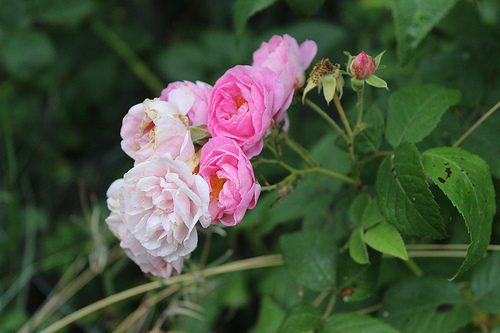

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [5]:
batch_size = 32
img_height = 180
img_width = 180

tf.keras.preprocessing을 이용하여 로드하기

image_dataset_from_direcotry - image_size : 이미지 크기 조정

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split = 0.2, subset = 'training', seed = 123, image_size = (img_height, img_width), batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split = 0.2, subset = 'validation', seed = 123, image_size = (img_height, img_width), batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


데이터 시각화

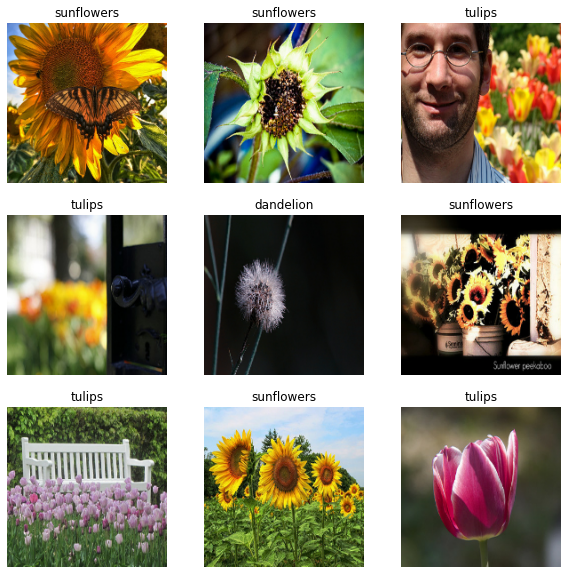

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape) # 마지막 차원 : 색상차원 RGB
  print(labels_batch.shape) # 32개 이미지에 해당하는 레이블
  break

(32, 180, 180, 3)
(32,)


데이터 표준화

RGB 채널 값은 [0, 255] 범위에 있음 - 신경망 범위는 [0, 1]이 이상적

In [15]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

# 디스크에서 데이터 생성

모델 훈련

In [21]:
num_classes = 5

model = tf.keras.Sequential([
                             tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
                             tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation = 'relu'),
                             tf.keras.layers.Dense(num_classes)
])

In [22]:
model.compile(
    optimizer = 'adam', loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [23]:
model.fit(train_ds, validation_data = val_ds, epochs = 3)

Epoch 1/3
92/92 [==============================] - 116s 1s/step - loss: 1.3184 - accuracy: 0.4152 - val_loss: 1.0925 - val_accuracy: 0.5245
Epoch 2/3
92/92 [==============================] - 108s 1s/step - loss: 1.0431 - accuracy: 0.5736 - val_loss: 1.0044 - val_accuracy: 0.6090
Epoch 3/3
92/92 [==============================] - 108s 1s/step - loss: 0.8807 - accuracy: 0.6594 - val_loss: 0.9534 - val_accuracy: 0.6063


미세 제어하기

In [25]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle = False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration = False)

In [26]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/dandelion/3823142577_dd5acd5ac6_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4846786944_2832c5c8b8.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/4669006062_6b3d260037_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/193878348_43571127b9_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/3109712111_75cea2dee6.jpg'


In [28]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [30]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [32]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


**함수 과정 이해하기**

In [37]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)

In [34]:
def decode_img(img):
  img = tf.io.decode_jpeg(img, channels = 3)
  return tf.image.resize(img, [img_height, img_width])

In [35]:
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [38]:
train_ds = train_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds =val_ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [39]:
for image, label in train_ds.take(1):
  print('Image shape: ', image.numpy().shape)
  print('Label: ', label.numpy())

Image shape:  (180, 180, 3)
Label:  0


성능을 위한 데이터세트 구성하기

In [40]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size = 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size = AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

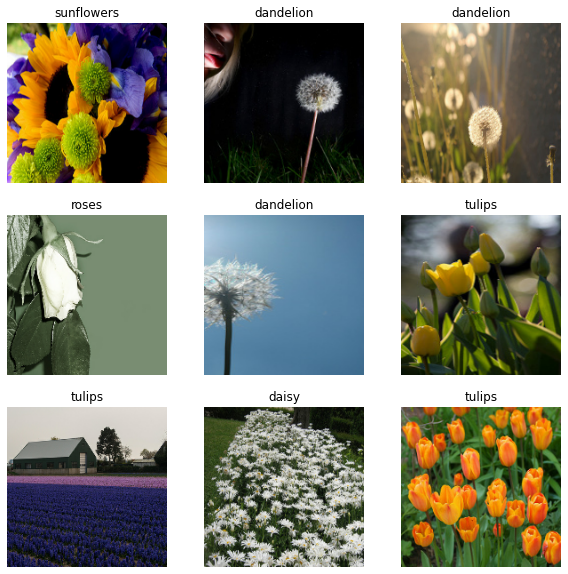

In [41]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize = (10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].numpy().astype('uint8'))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis('off')

In [42]:
model.fit(train_ds, validation_data = val_ds, epochs = 3)

Epoch 1/3
92/92 [==============================] - 116s 1s/step - loss: 0.7808 - accuracy: 0.6972 - val_loss: 0.7793 - val_accuracy: 0.7098
Epoch 2/3
92/92 [==============================] - 109s 1s/step - loss: 0.6118 - accuracy: 0.7636 - val_loss: 0.7501 - val_accuracy: 0.7180
Epoch 3/3
92/92 [==============================] - 108s 1s/step - loss: 0.4249 - accuracy: 0.8403 - val_loss: 0.8431 - val_accuracy: 0.6839


In [46]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [47]:
num_claases = metadata.features['label'].num_classes
print(num_classes)

5


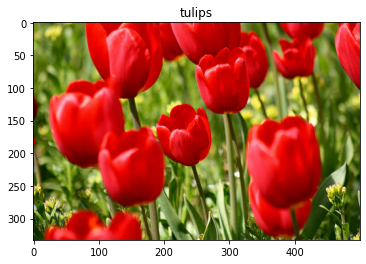

In [49]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [50]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)